# Resultado Fiscal - último mes reportado 2019


In [539]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format

In [540]:
def highlight_totales(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s ==s.loc[len(s)-1]
    return [('background-color: lightsteelblue')if v else '' for v in is_max] 

def dupl_var (val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'green' if val > 1 else 'black'
    return 'color: %s' % color

def read_ts_api_call(api_call):
    df = pd.read_csv(api_call, encoding="utf8", sep=",")
    df.indice_tiempo = pd.to_datetime(df.indice_tiempo)
    return df.set_index("indice_tiempo").to_period()

def highlight_subtotal(row, label_field, highlight_text): 
    return [    
    'background-color: lightblue'
    if highlight_text in row[label_field].lower() else ""
    for value in row]


# Los colores de fondo para las tablas están en ("https://matplotlib.org/2.0.0/examples/color/named_colors.html")

### Ingresos Totales (Formato IMIG)

In [541]:
# Armo los dataframes con los ids de los componentes de cada uno de los subtotales "tributarios", "rentas", "otros corrientes" y "capital"
 
it_tributarios= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_IVA_NETO_RROS_0_T_19_67,452.2_GANANCIASIAS_0_T_9_51,452.2_APORTES_COIAL_0_T_39_29,452.2_DEBITOS_CRTOS_0_T_16_22,452.2_BIENES_PERLES_0_T_17_26,452.2_IMPUESTOS_NOS_0_T_18_87,452.2_COMBUSTIBLLES_0_T_12_97,452.2_DERECHOS_EION_0_T_20_42,452.2_DERECHOS_IION_0_T_20_60,452.2_RESTO_TRIBIOS_0_T_17_0&limit=5000&format=csv")
it_rentas= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_FGS_COBRADERO_0_T_53_90,452.2_RESTO_RENTDAD_0_T_22_24&limit=5000&format=csv")
it_otros= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_INGRESOS_NIOS_0_T_23_2,452.2_TRANSFERENTES_0_T_25_22,452.2_RESTO_INGRTES_0_T_25_96&limit=5000&format=csv")
it_capital= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_INGRESOS_CTAL_0_T_16_75&limit=5000&format=csv")

In [542]:
#Como no contamos con los subtotales de Tributarios, Rentas, Otros Corrientes y capital para el armado del Resumen del mes IMIG,
#lo armamos trasponiendo los dataframe y sumando todos sus compoonentes. Esto nos va a permitir tener las series deseadas 
#y formar un dataframe con una estructura similar a la que queríamos llegar.

# it_tributarios.T.sum(), 
# it_rentas.T.sum(),
# it_otros.T.sum(),
# it_capital.T.sum(),
total=it_tributarios.T.sum() + it_rentas.T.sum() + it_otros.T.sum() + it_capital.T.sum()

# creamos un dataframe para Ingresos Totales con todos sus componentes. #VER COMO REORDENAR LAS FILAS!!!
ingresos_totales = pd.DataFrame({
    "I.a) Tributarios": it_tributarios.T.sum(), 
    "I.b) Rentas": it_rentas.T.sum(),
    "I.c) Otros_Corrientes": it_otros.T.sum(),
    "I.d) Capital": it_capital.T.sum(),
   })

ingresos_totales["Total Ingresos"]= ingresos_totales.sum(axis=1)




In [543]:
## PARA CONSIDERAR SIEMPRE EL ÚLTIMO PERIODO DE LA SERIE Y EL DEL AÑO ANTERIOR GENERO LAS VARIABLES periodo_actual y periodo_anio_anterior
periodo_actual = ingresos_totales.index.max()
periodo_anio_anterior = periodo_actual - 12
periodo_actual_str = str(periodo_actual)
periodo_anio_anterior_str = str(periodo_anio_anterior)

In [544]:
imig_it=ingresos_totales[
    (ingresos_totales.index==periodo_anio_anterior)|
    (ingresos_totales.index==periodo_actual)
].pivot_table(columns="indice_tiempo")

# Quisiera agregar la diferencia absoluta en $
# PORQUE NO ME SIRVE ÉSTA ASIGNACIÓN?? 
imig_it.columns = imig_it.columns.astype(str)
imig_it["var%_anual"]= round( (imig_it[periodo_actual_str] / imig_it[periodo_anio_anterior_str]) - 1, 4) 
imig_it["var$_anual"]= imig_it[ periodo_actual_str] - imig_it[periodo_anio_anterior_str]

In [545]:
imig_it_c= imig_it.reset_index()
imig_it_c= imig_it_c.rename(columns={"index": "Concepto"})
imig_it_c= imig_it_c.rename_axis(None, axis="columns")

In [546]:
#para ocultar el índice de la tabla, uso más adelante la función".style.hide_index()".

prop= imig_it_c["var$_anual"].T/float(imig_it_c[imig_it_c["Concepto"]== "Total Ingresos"]["var$_anual"])
p=prop[prop != 1].reset_index()
del p["index"]


def may_prop (val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'green' if val== float(imig_it_c.loc[p.idxmax(), "var$_anual"]) else 'black'
    return 'color: %s' % color


# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'white'),
  ('background-color', 'steelblue')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '13px'),
  ('font-weight', 'bold')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
]

In [547]:
print(chr(27)+"[1;3;30m"+"- En <var%_anual>, se resaltan en verde las variaciones que superan el 100%")
print(chr(27)+"[1;3;30m"+"- En <var$_anual>, se resalta en verde el concepto que más aportó al Total Ingresos")

(imig_it_c.style
.format({'var%_anual': "{:.2%}"})
.format({imig_gp_c.T[imig_gp_c.columns!="Concepto"].index[0]: "{:,.2f}"})
.format({imig_gp_c.T[imig_gp_c.columns!="Concepto"].index[1]: "{:,.2f}"})
.format({imig_gp_c.T[imig_gp_c.columns!="Concepto"].index[3]: "{:,.2f}"})
.apply(highlight_totales)
.applymap(may_prop, subset=["var$_anual"]).hide_index()
.applymap(dupl_var, subset=["var%_anual"]).hide_index()
.set_table_styles(styles)
)

- En <var%_anual>, se resaltan en verde las variaciones que superan el 100%
- En <var$_anual>, se resalta en verde el concepto que más aportó al Total Ingresos


Concepto,2018-08,2019-08,var%_anual,var$_anual
I.a) Tributarios,"195,384.70","306,663.70",56.95%,"111,279.00"
I.b) Rentas,"18,476.50","15,197.30",-17.75%,"-3,279.20"
I.c) Otros_Corrientes,"7,969.70","12,832.10",61.01%,"4,862.40"
I.d) Capital,"1,102.80","11,730.00",963.66%,"10,627.20"
Total Ingresos,"222,933.70","346,423.10",55.39%,"123,489.40"


### Gastos primarios (Formato IMIG)

In [548]:
# Armo los dataframes con los ids de los componentes de cada uno de los subtotales "tributarios", "rentas", "otros corrientes" y "capital"
 
gtos_prestaciones_sociales= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_JUBILACIONVAS_0_T_36_18,452.2_ASIGNACIONIJO_0_T_26_67,452.2_PENSIONES_VAS_0_T_26_164,452.2_PRESTACIONSJP_0_T_19_86,452.2_OTROS_PROGMAS_0_T_15_11&limit=5000&format=csv")
gtos_subsidios= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_ENERGIAGIA_0_T_7_56,452.2_TRANSPORTERTE_0_T_10_32,452.2_OTRAS_FUNCNES_0_T_15_25&limit=5000&format=csv")
gtos_funcionamiento= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_SALARIOSIOS_0_T_8_22,452.2_OTROS_GASTNTO_0_T_27_55&limit=5000&format=csv")
gtos_corrientes= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_TRANSFERENION_0_T_46_94,452.2_TRANSFERENIAL_0_T_53_66,452.2_TRANSFERENIAL_0_T_54_58,452.2_TRANSFERENLUD_0_T_42_88,452.2_TRANSFERENRAS_0_T_42_55&limit=5000&format=csv")
gtos_otros_ctes= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_OTROS_CORRDES_0_T_45_79,452.2_OTROS_CORRCAS_0_T_52_16,452.2_OTROS_CORRSTO_0_T_22_78&limit=5000&format=csv")

gtos_energia= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.2_CAPITAL_ENION_0_T_22_35,452.3_CAPITAL_ENIAS_0_M_40_18&limit=5000&format=csv")
gtos_transporte= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.3_CAPITAL_TRION_0_M_25_82,452.3_CAPITAL_TRIAS_0_M_43_35&limit=5000&format=csv")
gtos_educacion= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.3_CAPITAL_EDION_0_M_24_92,452.3_CAPITAL_EDIAS_0_M_42_42&limit=5000&format=csv")
gtos_vivienda= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.3_CAPITAL_VIION_0_M_23_52,452.3_CAPITAL_VIIAS_0_M_41_41&limit=5000&format=csv")
gtos_agua_alcantarillado= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.3_CAPITAL_AGION_0_M_41_40,452.3_CAPITAL_AGIAS_0_M_59_12&limit=5000&format=csv")
gtos_otros= read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=452.3_CAPITAL_OTION_0_M_20_10,452.3_CAPITAL_OTIAS_0_M_38_72&limit=5000&format=csv")


total_gpp= gtos_prestaciones_sociales.T.sum()+gtos_subsidios.T.sum()+ gtos_funcionamiento.T.sum()+gtos_corrientes.T.sum()+gtos_otros_ctes.T.sum()
total_gcp= gtos_energia.T.sum()+  gtos_transporte.T.sum()+ gtos_educacion.T.sum()+gtos_vivienda.T.sum()+ gtos_agua_alcantarillado.T.sum()+gtos_otros_ctes.T.sum()

# creamos un dataframe para Ingresos Totales con todos sus componentes. #VER COMO REORDENAR LAS FILAS!!!
gastos_primarios = pd.DataFrame({
    "II.a).1. Prestaciones Sociales": gtos_prestaciones_sociales.T.sum(), 
    "II.a).2. Subsidios económicos": gtos_subsidios.T.sum(),
    "II.a).3. Gastos de Funcionamiento y otros": gtos_funcionamiento.T.sum(),
    "II.a).4. Transferencias corrientes a provincias": gtos_corrientes.T.sum(),
    "II.a).5. Otros gastos corrientes": gtos_otros_ctes.T.sum(),
    "II.a)Total Gastos Corrientes Primarios":total_gpp,
    "II.b).1. Energia": gtos_energia.T.sum(), 
    "II.b).2. Transporte": gtos_transporte.T.sum(),
    "II.b).3. Educación": gtos_educacion.T.sum(),
    "II.b).4. Vivienda": gtos_vivienda.T.sum(),
    "II.b).5. Agua potable y alcantarillado": gtos_agua_alcantarillado.T.sum(),
    "II.b).6. Otros gastos de capital": gtos_otros_ctes.T.sum(),
    "II.b)Total Gastos de Capital":total_gcp
})

gastos_primarios["Total Gastos Primarios"]= gastos_primarios.sum(axis=1)



In [549]:
#imig_gp.index=imig_gp.index.to_period()

## PARA CONSIDERAR SIEMPRE EL ÚLTIMO PERIODO DE LA SERIE Y EL DEL AÑO ANTERIOR GENERO LAS VARIABLES periodo_actual y periodo_anio_anterior
periodo_actual = gastos_primarios.index.max()
periodo_anio_anterior = periodo_actual - 12
periodo_actual_str = str(periodo_actual)
periodo_anio_anterior_str = str(periodo_anio_anterior)

imig_gp=gastos_primarios[(gastos_primarios.index==periodo_anio_anterior)|(gastos_primarios.index==periodo_actual)].pivot_table(columns="indice_tiempo")
imig_gp["var%_anual"]= round( (imig_gp[periodo_actual] / imig_gp[periodo_anio_anterior]) - 1, 4)

# Quisiera agregar la diferencia absoluta en $
# PORQUE NO ME SIRVE ÉSTA ASIGNACIÓN?? 
imig_gp.columns = imig_gp.columns.astype(str)
imig_gp["var$_anual"]= imig_gp[str(object= periodo_actual_str)] - imig_gp[str(object=periodo_anio_anterior_str)]


In [550]:
imig_gp_c= imig_gp.reset_index()
imig_gp_c= imig_gp_c.rename(columns={"index": "Concepto"})
imig_gp_c= imig_gp_c.rename_axis(None, axis="columns")

In [551]:
#para ocultar el índice de la tabla, uso más adelante la función".style.hide_index()".


def may_prop (val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'green' if val==float(imig_gp_c.loc[p.idxmax(), "var$_anual"]) else 'black'
    return 'color: %s' % color


# Set CSS properties for th elements in dataframe
th_props = [
  ('font-size', '14px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'white'),
  ('background-color', 'steelblue')
  ]

# Set CSS properties for td elements in dataframe
td_props = [
  ('font-size', '13px'),
  ('font-weight', 'bold')
  ]

# Set table styles
styles = [
  dict(selector="th", props=th_props),
  dict(selector="td", props=td_props)
]

print(chr(27)+"[1;3;30m"+"- En <var%_anual>, se resaltan las variaciones que superan el 100%")


gp=(imig_gp_c.style
.format({'var%_anual': "{:.2%}"})
.format({imig_gp_c.T[imig_gp_c.columns!="Concepto"].index[0]: "{:,.2f}"})
.format({imig_gp_c.T[imig_gp_c.columns!="Concepto"].index[1]: "{:,.2f}"})
.format({imig_gp_c.T[imig_gp_c.columns!="Concepto"].index[3]: "{:,.2f}"})
.apply(highlight_totales)
.apply(highlight_subtotal, axis=1, label_field="Concepto", highlight_text=")total gastos")
.applymap(dupl_var, subset=["var%_anual"]).hide_index()
.set_table_styles(styles))
gp

#Faltaría resaltar los subtotales!!!

- En <var%_anual>, se resaltan las variaciones que superan el 100%


Concepto,2018-08,2019-08,var%_anual,var$_anual
II.a).1. Prestaciones Sociales,"129,012.90","183,235.20",42.03%,"54,222.30"
II.a).2. Subsidios económicos,"23,590.20","34,129.80",44.68%,"10,539.60"
II.a).3. Gastos de Funcionamiento y otros,"40,807.60","60,500.50",48.26%,"19,692.90"
II.a).4. Transferencias corrientes a provincias,"7,313.00","11,170.30",52.75%,"3,857.30"
II.a).5. Otros gastos corrientes,"12,780.60","19,644.30",53.70%,"6,863.70"
II.a)Total Gastos Corrientes Primarios,"213,504.30","308,680.10",44.58%,"95,175.80"
II.b).1. Energia,"1,917.30","2,881.80",50.31%,964.50
II.b).2. Transporte,"6,675.60","8,997.20",34.78%,"2,321.60"
II.b).3. Educación,940.30,"1,080.70",14.93%,140.40
II.b).4. Vivienda,"2,136.40","1,796.90",-15.89%,-339.50


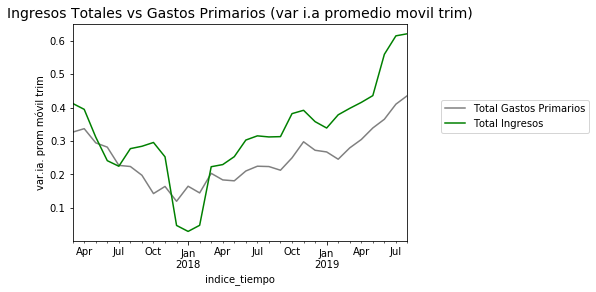

In [552]:
gp=gastos_primarios["Total Gastos Primarios"]
it= ingresos_totales["Total Ingresos"]
gp.rolling(3).mean().pct_change(12).plot(color="gray")
it.rolling(3).mean().pct_change(12).plot(color="green")
plt.title("Ingresos Totales vs Gastos Primarios (var i.a promedio movil trim)",fontsize=14)
plt.xlim("2017-03", periodo_actual);
plt.legend(loc=[1.1,0.5]);
plt.ylabel("var.ia. prom móvil trim");

In [553]:
# i=0
# while i < len(gp):
    
# if gp[i]>it[i]:
#     t[i]=1
#     i= i+1
# else:
#     t[i]=0


## Resumen ejecutivo

In [554]:
cod_mes= {1: "enero",
    2: "febrero",
    3: "marzo",
    4: "abril",
    5: "mayo",
    6: "junio",
    7: "julio",
    8: "agosto",
    9: "septiembre",
    10: "octubre",
    11: "noviembre",
    12: "diciembre"}

rp=pd.read_csv("https://apis.datos.gob.ar/series/api/series/?&ids=452.3_RESULTADO_RIO_0_M_18_54&limit=5000&format=csv")

rp["indice_tiempo"] = pd.to_datetime(rp["indice_tiempo"])
rp=rp.set_index("indice_tiempo")


mes_actual= rp.index.max().month

## PARA CONSIDERAR SIEMPRE EL ÚLTIMO PERIODO DE LA SERIE Y EL DEL AÑO ANTERIOR GENERO LAS VARIABLES periodo_actual y periodo_anio_anterior
rp.index=rp.index.to_period()
periodo_actual = rp.index.max()
periodo_anio_anterior = periodo_actual - 12

rp=rp[(rp.index==periodo_anio_anterior)|(rp.index==periodo_actual)].pivot_table(columns="indice_tiempo")

rp["var%_anual"]= round( (rp[periodo_actual] / rp[periodo_anio_anterior]) - 1, 4) * 100
#rp.loc["resultado_primario",
rp
rp.columns = rp.columns.astype(str)
rp_actual=int(round(rp.loc["resultado_primario", str(periodo_actual)],0))
rp_anterior=int(round(rp.loc["resultado_primario", str(periodo_anio_anterior)],0))
dif= int(rp.loc["resultado_primario", str(periodo_actual)] - rp.loc["resultado_primario", str(periodo_anio_anterior)])


In [555]:
i= rp[str(periodo_actual)]
#NO FUNCIONÓ DE ÉSTA FORMA
# def conv(a)
# return
# if a > 0:
#  print("superávit")
# else: print("déficit")

#REDISEÑO

if i[0]>0:
    if rp_anterior<0:
        print("Durante el mes de {} el Sector Público Nacional tuvo un superávit primario de $ {} millones, lo que implica una mejora de $ {} millones frente al déficit de $ {} millones registrado en igual mes de {}.".format(cod_mes[mes_actual], rp_actual, dif, -rp_anterior ,it_tributarios.index.max().year-1))
    else: print("Durante el mes de {} el Sector Público Nacional tuvo un superávit primario de $ {} millones, lo que implica una mejora de $ {} millones frente al déficit de $ {} millones registrado en igual mes de {}.".format(cod_mes[mes_actual], rp_actual, dif, rp_anterior ,it_tributarios.index.max().year-1))   
else:   
    if rp_anterior<0:
        print("Durante el mes de {} el Sector Público Nacional tuvo un déficit primario de $ {} millones, lo que implica una mejora de $ {} millones frente al déficit de $ {} millones registrado en igual mes de {}.".format(cod_mes[mes_actual], rp_actual, dif, -rp_anterior ,it_tributarios.index.max().year-1))
    else: print("Durante el mes de {} el Sector Público Nacional tuvo un déficit primario de $ {} millones, lo que implica una mejora de $ {} millones frente al déficit de $ {} millones registrado en igual mes de {}.".format(cod_mes[mes_actual], rp_actual, dif, rp_anterior ,it_tributarios.index.max().year-1))   
        
#si es posible agregar separador de miles.

Durante el mes de agosto el Sector Público Nacional tuvo un superávit primario de $ 13746 millones, lo que implica una mejora de $ 24102 millones frente al déficit de $ 10356 millones registrado en igual mes de 2018.


In [556]:
a= float(imig_it_c[imig_it_c.Concepto=="Total Ingresos"]["var%_anual"])*100
b= float(imig_gp_c[imig_gp_c.Concepto=="Total Gastos Primarios"]["var%_anual"])*100

print("Los recursos totales crecieron {}% en términos interanuales (i.a.), {} puntos porcentuales (p.p.) más en relación a los gastos primarios que tuvieron un incremento de {}% i.a.".format(round(imig_it.loc["Total Ingresos","var%_anual"],3)*10*10,int(round(a-b,0)),round(imig_gp.loc["Total Gastos Primarios","var%_anual"],3)*100))

Los recursos totales crecieron 55.400000000000006% en términos interanuales (i.a.), 10 puntos porcentuales (p.p.) más en relación a los gastos primarios que tuvieron un incremento de 44.9% i.a.


### Resultado Primario en términos del PBI



In [557]:
pbi_rp=read_ts_api_call("https://apis.datos.gob.ar/series/api/series/?ids=9.2_PPC_2004_T_22,452.3_RESULTADO_RIO_0_M_18_54&collapse=quarter&collapse_aggregation=sum&limit=5000&format=csv")
pbi_rp= pbi_rp[pbi_rp.index>="20170101"]

#como no tenemos info del pbi estimado para el 2do trim 2019, repetimos el del 
# último trim informado

pbi_rp["resultado_primario"]= pbi_rp["resultado_primario"] *3

In [558]:
# rp=pd.read_csv("https://apis.datos.gob.ar/series/api/series/?ids=452.3_RESULTADO_RIO_0_M_18_54&collapse=quarter&collapse_aggregation=sum&limit=5000&format=csv")

# rp= pbi_rp[pbi_rp.index>="20170101"]
# rp.head()

In [559]:
## PARA CONSIDERAR SIEMPRE EL ÚLTIMO PERIODO DE LA SERIE Y EL DEL AÑO ANTERIOR GENERO LAS VARIABLES periodo_actual y periodo_anio_anterior
periodo_actual = ingresos_totales.index.max()
periodo_anio_anterior = periodo_actual - 12

In [560]:
#creo un df llamado a para poder tener los pbi promedios trimestrales en todo el año

pbi=pbi_rp["pib_precios_corrientes"]
pbi=pbi.reset_index()
pbi_prom= pbi.groupby(pbi.indice_tiempo.dt.year).mean()
#pbi_prom termina siendo una nueva serie pero con un índice temporal expresado en años


In [561]:
dif=pbi_rp.index.year.max() - pbi_rp.index.year.min()
a_min=pbi_rp.index.year.min()

#ACUMULA LOS MONTOS DE LOS CUATRIMESTRES CUYOS REGISTROS ANUALES ESTÉN COMPLETOS (NO INCLUYE EL AÑO EN CURSO YA QUE ÉSTE PUEDE NO ESTAR COMPLETO)
i= 0
while i< dif :
    print ("")
    pbi_rp.loc[(pbi_rp.index.year==a_min+i) & (pbi_rp.index.quarter==2), "resultado_primario"] = pbi_rp.loc[(a_min+i).astype(str)+"-01-01", "resultado_primario"]+pbi_rp.loc[(a_min+i).astype(str)+"-04-01", "resultado_primario"]
    pbi_rp.loc[(pbi_rp.index.year==a_min+i) & (pbi_rp.index.quarter==3), "resultado_primario"] = pbi_rp.loc[(a_min+i).astype(str)+"-04-01", "resultado_primario"]+pbi_rp.loc[(a_min+i).astype(str)+"-07-01", "resultado_primario"]
    pbi_rp.loc[(pbi_rp.index.year==a_min+i) & (pbi_rp.index.quarter==4), "resultado_primario"] = pbi_rp.loc[(a_min+i).astype(str)+"-07-01", "resultado_primario"]+pbi_rp.loc[(a_min+i).astype(str)+"-10-01", "resultado_primario"]
    i= i+1

# Utilizo éste comando para elegir la columna deseada Ej: pbi_rp.index.year.max().astype(str)+"-"+str((2+t)*3-2).zfill(2)+"-01"

#ACUMULA LOS MONTOS DE LOS CUATRIMESTRES DEL ÚLTIMO AÑO
t=0
t_añomax= pbi_rp[pbi_rp.index.year==pbi_rp.index.year.max()].index.quarter.max()
dift= t_añomax-2

while t< dift+1 :
    print ("")
    pbi_rp.loc[(pbi_rp.index.year==pbi_rp.index.year.max()) & (pbi_rp.index.quarter==2+t), "resultado_primario"] = pbi_rp.loc[pbi_rp.index.year.max().astype(str)+"-"+str((2+t)*3-5).zfill(2)+"-01", "resultado_primario"]+pbi_rp.loc[ pbi_rp.index.year.max().astype(str)+"-"+str((2+t)*3-2).zfill(2)+"-01", "resultado_primario"]
    t= t+1

# pbi_rp.loc[(pbi_rp.index.year==anio) & (pbi_rp.index.quarter==3), "resultado_primario"] = pbi_rp.loc[anio.astype(str)+"-04-01", "resultado_primario"]+pbi_rp.loc[anio.astype(str)+"-07-01", "resultado_primario"]
# pbi_rp.loc[(pbi_rp.index.year==anio) & (pbi_rp.index.quarter==4), "resultado_primario"] = pbi_rp.loc[anio.astype(str)+"-07-01", "resultado_primario"]+pbi_rp.loc[anio.astype(str)+"-10-01", "resultado_primario"]


In [562]:
#reemplazo los pib de la tabla con los promedios calculados en "a"
for anio in range(2017,2020):
    pbi_rp.loc[pbi_rp.index.year==anio, "pib_precios_corrientes_prom_anual"]= pbi_prom.loc[anio,"pib_precios_corrientes"]

In [563]:
columnsTitles= ["resultado_primario","pib_precios_corrientes", "pib_precios_corrientes_prom_anual"]

pbi_rp= (pbi_rp.T.reindex(columnsTitles)).T 

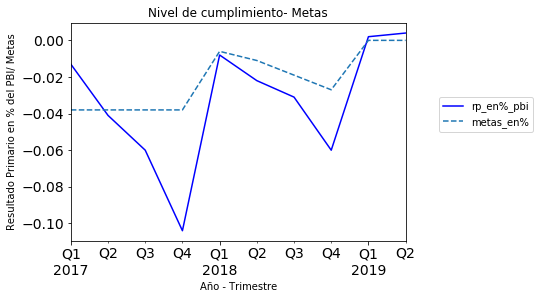

In [564]:
#Ahora si, es posible calcular el rp en términos del pbi

pbi_rp["metas_en%"]= [ -3.8/100, -3.8/100, -3.8/100, -3.8/100, -0.6/100, -1.1/100, -1.9/100, -2.7/100, 0, 0 ]
pbi_rp["metas_en%"]= pd.to_numeric(pbi_rp["metas_en%"])
pbi_rp["metas_en%"]= pbi_rp["metas_en%"].astype("float64")
pbi_rp["rp_en%_pbi"]=round((pbi_rp["resultado_primario"] / pbi_rp["pib_precios_corrientes"]),3)

a=pbi_rp.plot(y='rp_en%_pbi', title="Nivel de cumplimiento- Metas", color="blue", fontsize=14)
pbi_rp.plot(y='metas_en%',ax=a, style='--')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel("Resultado Primario en % del PBI/ Metas")
plt.xlabel("Año - Trimestre");
plt.legend(loc=[1.1,0.5]);

In [565]:
# pbi_rp[pbi_rp.columns!="Concepto"].index[1]
pbi_rp= pbi_rp.reset_index()
pbi_rp= pbi_rp.rename_axis(None, axis="columns")

In [566]:
pbi_rp_c= (pbi_rp.style
    .format({'metas_en%': "{:.2%}"})
    .format({'rp_en%_pbi': "{:.2%}"})
    .format({"resultado_primario": "{:,.2f}"})
    .format({"pib_precios_corrientes": "{:,.2f}"})
    .format({"pib_precios_corrientes_prom_anual": "{:,.2f}"})
    .hide_index()
    .set_table_styles(styles))
pbi_rp_c

indice_tiempo,resultado_primario,pib_precios_corrientes,pib_precios_corrientes_prom_anual,metas_en%,rp_en%_pbi
2017Q1,"-124,031.40","9,207,047.99","10,644,778.80",-3.80%,-1.30%
2017Q2,"-432,856.80","10,602,469.31","10,644,778.80",-3.80%,-4.10%
2017Q3,"-667,136.70","11,070,090.10","10,644,778.80",-3.80%,-6.00%
2017Q4,"-1,212,426.90","11,699,507.79","10,644,778.80",-3.80%,-10.40%
2018Q1,"-93,002.70","12,295,597.17","14,605,790.35",-0.60%,-0.80%
2018Q2,"-317,474.10","14,242,781.39","14,605,790.35",-1.10%,-2.20%
2018Q3,"-459,945.00","14,960,937.95","14,605,790.35",-1.90%,-3.10%
2018Q4,"-1,016,961.90","16,923,844.88","14,605,790.35",-2.70%,-6.00%
2019Q1,"31,041.00","17,555,535.05","19,528,919.38",0.00%,0.20%
2019Q2,"90,663.30","21,502,303.71","19,528,919.38",0.00%,0.40%
